## Import Libraries and load data

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Paths
# df = pd.read_csv("Proprocessed_Dataset.csv")  # update this to your notebook's directory if needed
df = pd.read_csv("C:/Users/ianta/Desktop/Ian/University (NUS)/Y4S1/BT4103 Business Analytics Capstone Project/Github Repo/Proprocessed_Dataset.csv")
df.head()

In [ ]:
# Drop index column, if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0", "OPERATION_ID"])

df.head()

In [32]:
MODEL_DIR = Path("xgb_models")
MODEL_DIR.mkdir(exist_ok=True)

# Random seed
RANDOM_STATE = 42

In [33]:
import sys, xgboost
print(sys.executable)
print(xgboost.__version__)

c:\Users\ianta\anaconda3\python.exe
3.0.0


In [ ]:
import optuna

def frequency_encode(df, col):
    freq = df[col].value_counts() / len(df)
    df[col] = df[col].map(freq)
    return df

def target_encode(train, test, col, target):
    means = train.groupby(col)[target].mean()
    train[col] = train[col].map(means)
    test[col] = test[col].map(means)
    test[col] = test[col].fillna(train[target].mean())
    return train, test

# === 3. Define utility function to train and evaluate XGBoost model ===
def train_xgboost_for_target(df, target_col):
    print(f"\n=== Predicting {target_col} ===")

    # Drop missing targets
    df_model = df.dropna(subset=[target_col]).copy()

    # Define X, y
    X = df_model.drop(columns=[target_col])
    y = df_model[target_col]

    # Drop the other target (to prevent leakage)
    other_target = "ACTUAL_USAGE_DURATION" if target_col == "ACTUAL_SURGERY_DURATION" else "ACTUAL_SURGERY_DURATION"
    if other_target in X.columns:
        X = X.drop(columns=[other_target])

    # --- HANDLE CATEGORICALS ---
    cat_cols = X.select_dtypes(include=["object"]).columns
    high_card_cols = [c for c in cat_cols if X[c].nunique() > 50]
    low_card_cols  = [c for c in cat_cols if X[c].nunique() <= 50]

    print(f"→ High-cardinality cols (freq-encoded): {high_card_cols}")
    print(f"→ Low-cardinality cols (one-hot): {low_card_cols}")

    # Frequency encode high-cardinality
    for c in high_card_cols:
        X = frequency_encode(X, c)

    # One-hot encode low-cardinality
    X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)

    X.columns = (
        X.columns.astype(str)
        .str.replace('[', '(', regex=False)
        .str.replace(']', ')', regex=False)
        .str.replace('<', '_lt_', regex=False)
        .str.replace('>', '_gt_', regex=False)
    )

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    # --- OPTUNA HYPERPARAMETER TUNING ---
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'n_estimators': 2000,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
            'random_state': RANDOM_STATE,
            'n_jobs': -1,
        }

        model = XGBRegressor(**params)
        rmse = -cross_val_score(
            model, X_train, y_train,
            scoring='neg_root_mean_squared_error',
            cv=3, n_jobs=-1
        ).mean()
        return rmse

    print("Tuning hyperparameters with Optuna (≈ 170–285 sec per trial)...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100, show_progress_bar=True)

    print("Best parameters:", study.best_params)
    best_params = study.best_params

    # --- FINAL MODEL TRAINING ---
    model = XGBRegressor(
        **best_params,
        n_estimators=3000,
        early_stopping_rounds=200,
        eval_metric="rmse",
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Evaluate
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    mae_train  = mean_absolute_error(y_train, y_pred_train)
    r2_train   = r2_score(y_train, y_pred_train)

    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    r2_test   = r2_score(y_test, y_pred_test)

    print("\n--- Performance ---")
    print(f"Train: RMSE={rmse_train:.2f}, MAE={mae_train:.2f}, R²={r2_train:.3f}")
    print(f" Test: RMSE={rmse_test:.2f}, MAE={mae_test:.2f}, R²={r2_test:.3f}")

    # Feature importance
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(9, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(10))
    plt.title(f"Top 10 Features for {target_col}")
    plt.tight_layout()
    plt.show()

        # --- SAVE OUTPUTS ---
    print("\nSaving model outputs...")

    # 1. Save model
    model.save_model(MODEL_DIR / f"model_{target_col}.json")

    # 2. Save predictions
    preds = pd.DataFrame({'y_true': y_test, 'y_pred': model.predict(X_test)})
    preds.to_csv(MODEL_DIR / f"predictions_{target_col}.csv", index=False)

    # 3. Save metrics
    metrics = pd.DataFrame([{
        'target': target_col,
        'RMSE_Train': rmse_train,
        'MAE_Train': mae_train,
        'R2_Train': r2_train,
        'RMSE_Test': rmse_test,
        'MAE_Test': mae_test,
        'R2_Test': r2_test
    }])
    metrics.to_csv(MODEL_DIR / f"metrics_{target_col}.csv", index=False)

    # 4. Save feature importance
    importance.to_csv(MODEL_DIR / f"feature_importance_{target_col}.csv", index=False)

    # 5. Save Optuna results
    study.trials_dataframe().to_csv(MODEL_DIR / f"optuna_trials_{target_col}.csv", index=False)
    pd.DataFrame([best_params]).to_csv(MODEL_DIR / f"best_params_{target_col}.csv", index=False)

    print(f"All outputs saved in: {MODEL_DIR.resolve()}\n")

    return model, importance, X_train, X_test, y_train, y_test


=== Predicting ACTUAL_SURGERY_DURATION ===
→ High-cardinality cols (freq-encoded): ['ROOM', 'SURGEON', 'ANAESTHETIST_MCR_NO', 'ADMISSION_WARD', 'ADMISSION_BED']
→ Low-cardinality cols (one-hot): ['CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY', 'DISCIPLINE', 'ANESTHESIA', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE', 'BLOOD', 'IMPLANT', 'DIAGNOSIS', 'Delay_Category']


[I 2025-10-27 22:13:50,385] A new study created in memory with name: no-name-72ac8883-bc59-4b92-805a-7930dbe32185


Tuning hyperparameters with Optuna (≈ 170–285 sec per trial)...


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-10-27 22:17:01,357] Trial 0 finished with value: 45.26930094251474 and parameters: {'learning_rate': 0.03817926632754145, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8889487078914531, 'colsample_bytree': 0.734970572540933, 'reg_lambda': 4.133822580295405, 'reg_alpha': 0.0025279436811886935}. Best is trial 0 with value: 45.26930094251474.
[I 2025-10-27 22:20:55,278] Trial 1 finished with value: 46.18795495705166 and parameters: {'learning_rate': 0.045275116104884675, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.837964750411802, 'colsample_bytree': 0.6226052770927919, 'reg_lambda': 3.5777374392627235, 'reg_alpha': 1.246888752325884}. Best is trial 0 with value: 45.26930094251474.
[I 2025-10-27 22:24:22,711] Trial 2 finished with value: 46.758644023803676 and parameters: {'learning_rate': 0.028071462935478263, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6600041459454795, 'colsample_bytree': 0.8710177238689523, 'reg_lambda': 4.116533512382203, 'reg_alph

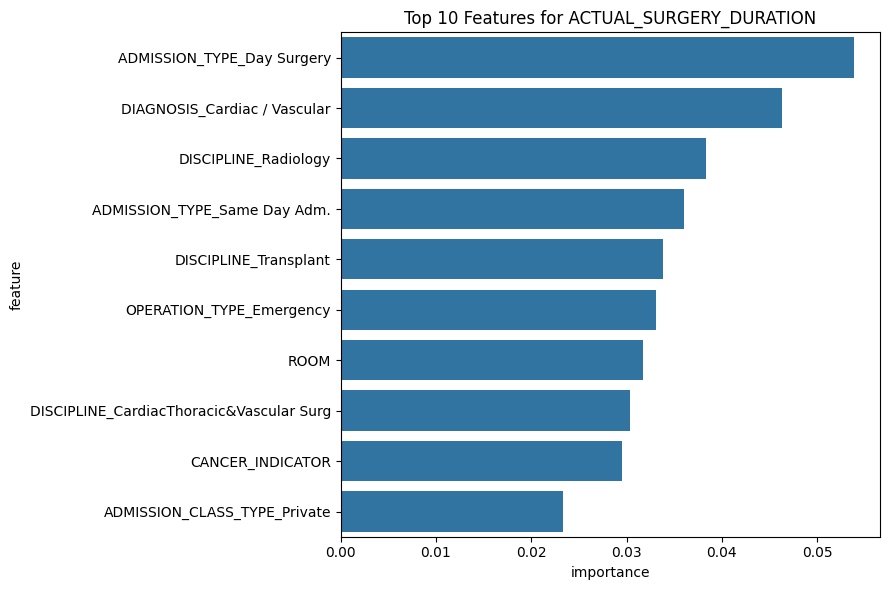


Saving model outputs...
All outputs saved in: C:\Users\ianta\Desktop\Ian\University (NUS)\Y4S1\BT4103 Business Analytics Capstone Project\Github Repo\Models\xgb_models



In [35]:
# === Run for ACTUAL_SURGERY_DURATION ===
model_surgery, imp_surgery, X_train_surgery, X_test_surgery, y_train_surgery, y_test_surgery = train_xgboost_for_target(df, "ACTUAL_SURGERY_DURATION")

<Figure size 900x1000 with 0 Axes>

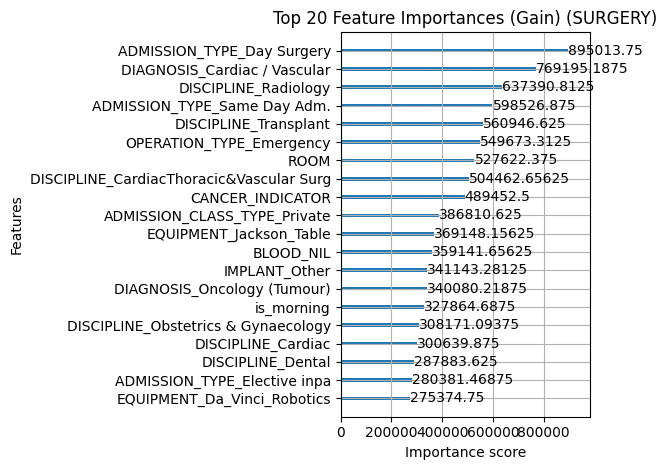

In [36]:
plt.figure(figsize=(9, 10))
plot_importance(model_surgery, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importances (Gain) (SURGERY)")
plt.tight_layout()
plt.show()

In [ ]:
# === 3. Compute predictions and residuals ===
y_pred_train_surgery = model_surgery.predict(X_train_surgery)
y_pred_test_surgery  = model_surgery.predict(X_test_surgery)

resid_train_surgery = y_train_surgery - y_pred_train_surgery
resid_test_surgery  = y_test_surgery - y_pred_test_surgery

# === 4. Plot residuals vs fitted for train ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_train_surgery, y=resid_train_surgery, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted values (Train)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Train)")
plt.tight_layout()
plt.show()

# === 5. Plot residuals vs fitted for test ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_test_surgery, y=resid_test_surgery, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted values (Test)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Test)")
plt.tight_layout()
plt.show()


=== Predicting ACTUAL_USAGE_DURATION ===
→ High-cardinality cols (freq-encoded): ['ROOM', 'SURGEON', 'ANAESTHETIST_MCR_NO', 'ADMISSION_WARD', 'ADMISSION_BED']
→ Low-cardinality cols (one-hot): ['CASE_STATUS', 'OPERATION_TYPE', 'EMERGENCY_PRIORITY', 'DISCIPLINE', 'ANESTHESIA', 'ADMISSION_STATUS', 'ADMISSION_CLASS_TYPE', 'ADMISSION_TYPE', 'BLOOD', 'IMPLANT', 'DIAGNOSIS', 'Delay_Category']


[I 2025-10-27 22:32:38,544] A new study created in memory with name: no-name-881d0c72-6a7c-4fac-9452-088a8dc2f13a


Tuning hyperparameters with Optuna (≈ 170–285 sec per trial)...


  0%|          | 0/4 [00:00<?, ?it/s]

[I 2025-10-27 22:36:59,734] Trial 0 finished with value: 50.44562473328995 and parameters: {'learning_rate': 0.01670166154479082, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.9542239309867733, 'colsample_bytree': 0.9860159423621091, 'reg_lambda': 4.599272780188901, 'reg_alpha': 1.307272053262932}. Best is trial 0 with value: 50.44562473328995.
[I 2025-10-27 22:40:56,850] Trial 1 finished with value: 52.242526022600806 and parameters: {'learning_rate': 0.03879694796078746, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6304437924543409, 'colsample_bytree': 0.5062621327076848, 'reg_lambda': 1.7195226374378454, 'reg_alpha': 1.7656405759191958}. Best is trial 0 with value: 50.44562473328995.
[I 2025-10-27 22:46:12,764] Trial 2 finished with value: 49.58544717974413 and parameters: {'learning_rate': 0.03272832150662083, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.92006738644942, 'colsample_bytree': 0.9863757064465898, 'reg_lambda': 0.9013464312882413, 'reg_alpha': 

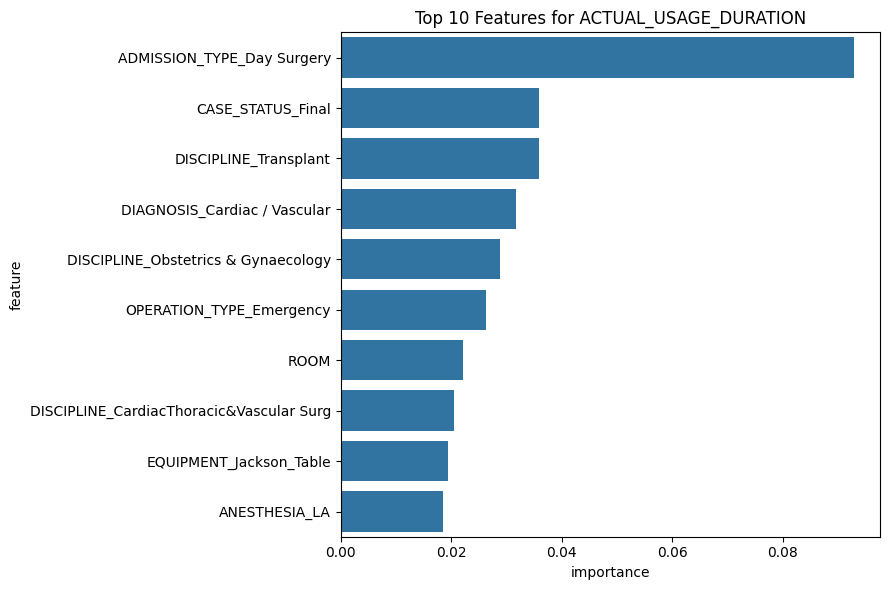


Saving model outputs...
All outputs saved in: C:\Users\ianta\Desktop\Ian\University (NUS)\Y4S1\BT4103 Business Analytics Capstone Project\Github Repo\Models\xgb_models



In [38]:
# === Run for ACTUAL_USAGE_DURATION ===
model_usage, imp_usage, X_train_usage, X_test_usage, y_train_usage, y_test_usage = train_xgboost_for_target(df, "ACTUAL_USAGE_DURATION")
model_usage.save_model("xgb_models/model_usage.json")

<Figure size 900x1000 with 0 Axes>

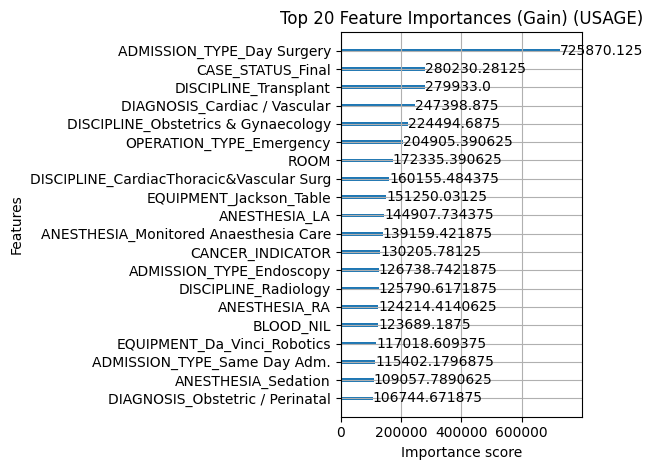

In [39]:
plt.figure(figsize=(9, 10))
plot_importance(model_usage, importance_type="gain", max_num_features=20)
plt.title("Top 20 Feature Importances (Gain) (USAGE)")
plt.tight_layout()
plt.show()

In [ ]:
# === 3. Compute predictions and residuals ===
y_pred_train_usage = model_usage.predict(X_train_usage)
y_pred_test_usage  = model_usage.predict(X_test_usage)

resid_train_usage = y_train_usage - y_pred_train_usage
resid_test_usage  = y_test_usage - y_pred_test_usage

# === 4. Plot residuals vs fitted for train ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_train_usage, y=resid_train_usage, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted values (Train)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Train)")
plt.tight_layout()
plt.show()

# === 5. Plot residuals vs fitted for test ===
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred_test_usage, y=resid_test_usage, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Fitted values (Test)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Test)")
plt.tight_layout()
plt.show()